#  Projeto nº3: Aprendizagem Automática

## Introdução à Inteligência Artificial edição 2021/22

### Imports adicionais:

In [2]:
from joblib.logger import PrintTime
from sklearn.tree import DecisionTreeClassifier, plot_tree # árvore de decisão
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.model_selection import train_test_split, cross_val_score # cross-validation
from sklearn.preprocessing import StandardScaler # normalização dos atributos
from sklearn.cluster import KMeans
import numpy as np 
import matplotlib.pyplot as plt # gráficos
from utilsAA import * # módulo distribuido com o guião com funções auxiliares
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

### Etapa 1: Carregar o conjunto de dados

Para fazer o load dos dados utilizamos a função indicada no enunciado do módulo `utilsAA`

In [3]:
train_data, classes, feature_names, train_target = load_data("/home/joao/Documents/uni/sem_5/int_artificial/proj_3/heart.csv")


### Etapa 2: Processar os dados

Podemos verificar que nem todos os dados deste conjunto são dados númericos, logo não podem ser usados pelo sklearn. Sendo este o caso temos de os normalizar utilizado as ferramentas disponibilizadas pelo módulo. Para alem disso este conjunto traz consigo um identificador de pessoa que deve ser removido também.

In [4]:
print("Antes de remover o identificador: \n", train_data[:5])

#remover o identificador de pessoa
train_data = train_data[:,1:]
feature_names = feature_names[1:]

print("Após remover o identificador: \n", train_data[:5])

Antes de remover o identificador: 
 [[121 54 'F' 'ATA' 120 230 1 'Normal' 140 'N' 0.0 'Up']
 [367 56 'M' 'ATA' 126 166 0 'ST' 140 'N' 0.0 'Up']
 [161 49 'M' 'NAP' 140 187 0 'Normal' 172 'N' 0.0 'Up']
 [483 61 'M' 'ASY' 141 292 0 'ST' 115 'Y' 1.7 'Flat']
 [209 53 'M' 'NAP' 120 195 0 'Normal' 140 'N' 0.0 'Up']]
Após remover o identificador: 
 [[54 'F' 'ATA' 120 230 1 'Normal' 140 'N' 0.0 'Up']
 [56 'M' 'ATA' 126 166 0 'ST' 140 'N' 0.0 'Up']
 [49 'M' 'NAP' 140 187 0 'Normal' 172 'N' 0.0 'Up']
 [61 'M' 'ASY' 141 292 0 'ST' 115 'Y' 1.7 'Flat']
 [53 'M' 'NAP' 120 195 0 'Normal' 140 'N' 0.0 'Up']]


In [5]:
# codificar atributo Sex
train_data[:,1] = encode_feature(train_data[:,1]) 
# codificar atributo FastingBS
train_data[:,5] = encode_feature(train_data[:,5])
# codificar atributo RestingECG
train_data[:,6] = encode_feature(train_data[:,6]) 
# codificar atributo ExerciseAngina
train_data[:,8] = encode_feature(train_data[:,8]) 
# codificar atributo ChestPainType
train_data, feature_names = one_hot_encode_feature(train_data, 2, feature_names)
# codificar atributo ST_slope
train_data, feature_names = one_hot_encode_feature(train_data, 9, feature_names)

print(train_data[:5])


[[54 0.0 120 230 1.0 1.0 140 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0]
 [56 1.0 126 166 0.0 2.0 140 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0]
 [49 1.0 140 187 0.0 1.0 172 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0]
 [61 1.0 141 292 0.0 2.0 115 1.0 1.7 1.0 0.0 0.0 0.0 0.0 1.0 0.0]
 [53 1.0 120 195 0.0 1.0 140 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0]]


- Já que os dados de teste fornecidos não estão etiquetados, não são uteis para as abordagens de aprendizagem supervisionada que vamos implementar. No entanto podemos utilizar uma parte dos dados de treino para esse fim utilizando a função `train_test_split` do sklearn:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_data, classes, random_state=50)

### Etapa 3: Procura do melhor modelo

Com os dados normalizados e processados de forma a poderem ser utilizados no sklearn é possível começar a treinar alguns modelos sobre eles.


O primeiro modelo a testar serão as arvores de decisão:

Exactidão no DecisionTreeClassifier: 0.7628205128205128


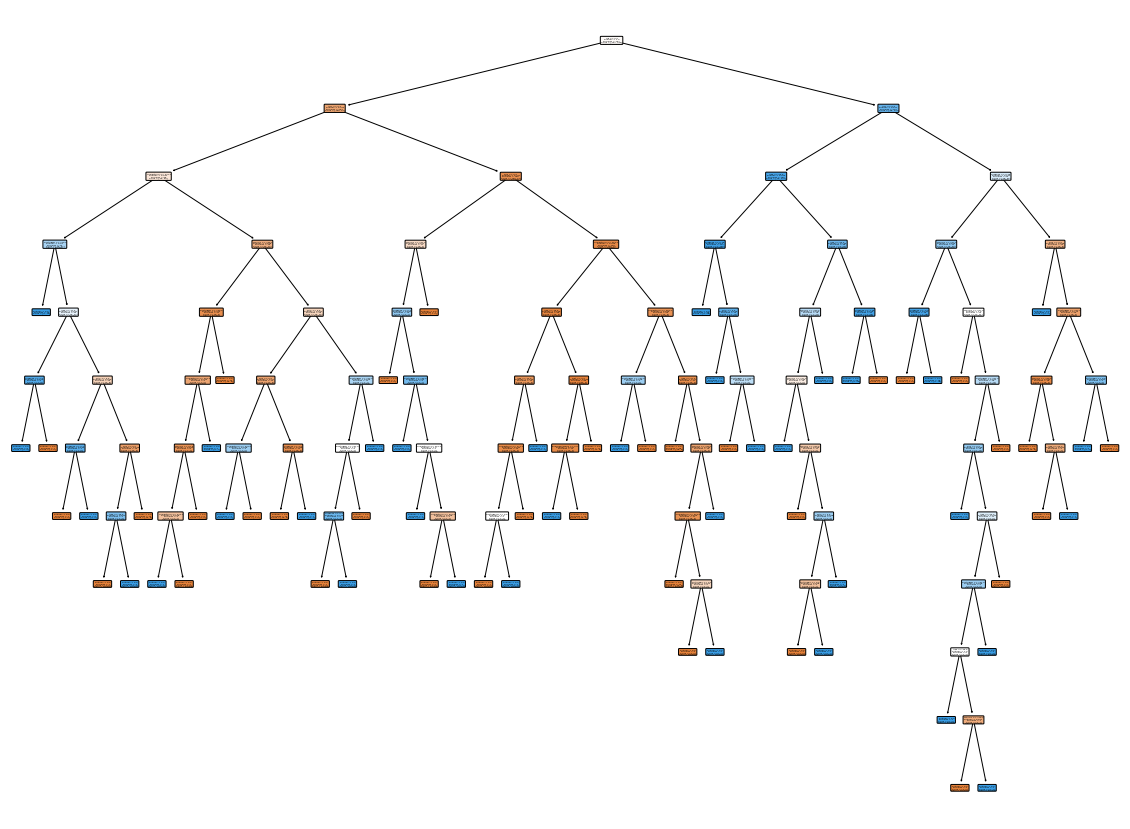

In [7]:
#DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train, y_train)
y_pred_p = dtc.predict(X_test)
print("Exactidão no DecisionTreeClassifier:",  accuracy_score(y_test,y_pred_p))
plt.figure(figsize=[20,15])
plot_tree(dtc,
          feature_names=feature_names,
          class_names=classes,
          filled=True, rounded=True)
plt.show()

No caso acima não estamos a fazer a devida cross-validation, 
no entanto podemos verificar que a accuracy do modelo é de <span style="color:red"> apenas ~75%</span> . É de esperar dado que nenhum dos parametros do classificador foram ajustados. Para saber quais são os melhores valores dos parametros dos diversos modelos, vamos usar a classe `GridSearchCV` para procurar e avaliar todas as possibilidades num range de opções pre-definido, que, como bonus, também efetua a cross-validation no modelo que está a testar.

In [8]:
dtc_parameters = {
    'criterion': ["gini", "entropy"],
    'splitter' : ["best", "random"],
    'max_depth': list(range(1,10)),
    'min_samples_leaf': list(range(1,3)),
    'min_samples_split': [2, 3, 4, 5]
} # parametros a serem testados

dtc = DecisionTreeClassifier() #classificador a utilizar

dtc_search = GridSearchCV(dtc, dtc_parameters)
dtc_search.fit(X_train, y_train)

y_pred_dtc = dtc_search.predict(X_test)
print("Com os parametros: ", dtc_search.best_params_)
print("A arvore de decisão obteve a accuracy: ", dtc_search.best_score_)

Com os parametros:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'splitter': 'random'}
A arvore de decisão obteve a accuracy:  0.8286662091054678


Apenas utilizando a grid search em alguns parametros a accuracy melhorou significativamente (<span style="color:#22afff">9%</span>) e por isso este é um metodo eficaz para encontrar os melhores hyper-parametros para os classificadores.  

Uma grid search exaustiva não é mais que uma abstração a escrever varios ciclos for com os ranges pretendidos, o que rapidamente se torna dispendioso em termos computacionais ( o algoritmo passa a ser da ordem <span style="color:#22afff">$O(n^k)$</span> com k sendo o numero de parametros que fazemos variar). Por isso dependendo da situação podemos utilizar abordagens mais sofisticadas como a `RandomizedSearchCV`, `HalvingGridSearchCV` e `HalvingRandomSearchCV`
(<a href="https://scikit-learn.org/stable/modules/grid_search.html#grid-search">`referencias para o grid_search`</a>).

No entanto as arvores de decisão são apenas um dos varios modelos possiveis, o k vizinhos mais proximos é outro deles:

In [12]:
knn = KNeighborsClassifier()
knn_parameters = {  'n_neighbors': list(range(1, 300, 5)),
                    'leaf_size': list(range(200, 1000, 15)),
                    'p': [1,2,3],
                    'weights': ('uniform', 'distance'),
                    'metric': ('minkowski', 'chebyshev'),
                    'algorithm' : ('auto', 'ball_tree', 'kd_tree', 'brute')
}

parameters_KNN = {  'n_neighbors': list(range(300, 420, 50)),
                    'leaf_size': [1, 5, 10, 20, 30, 40, 50, 100],
                    'p': (1, 2, 3),
                    'weights': ('uniform', 'distance'),
                    'metric': ('minkowski', 'chebyshev'),
                    'algorithm' : ('auto', 'ball_tree', 'kd_tree', 'brute')
                    }

knn_search = GridSearchCV(
    estimator=knn,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = None,
    cv = 10
)
knn_search.fit(X_train, y_train)
y_pred_knn = knn_search.predict(X_test)

print("Com os parametros: ", knn_search.best_params_)
print("KNN obteve a accuracy: ", knn_search.best_score_)

Com os parametros:  {'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 350, 'p': 1, 'weights': 'distance'}
KNN obteve a accuracy:  0.7238205365402405


De forma analoga podemos verificar quais são os modelos que melhor aprendem sobre o conjunto de dados em questão. 

In [21]:
#Perceptron
perc = Perceptron()
perc_parameters = {'alpha': list(np.linspace(0.001, 1, 10)),
                   'max_iter': [500, 10000],
                   'eta0': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
                   'l1_ratio': list(np.linspace(0.001, 1, 10)),
}

# neste caso o scorer default gerava um erro na avaliação, por isso tivemos de criar um
f1_scorer = make_scorer(f1_score, pos_label="Heart disease") #Normal
perc_search = GridSearchCV(
    estimator = perc,
    param_grid = perc_parameters,
    scoring = f1_scorer,
    cv = 10
)

perc_search.fit(X_train, y_train)
y_pred_perc = perc_search.predict(X_test)

print("Com os parametros: ", perc_search.best_params_ )
print("Perceptron obteve a accuracy: ", perc_search.best_score_ )

Com os parametros:  {'alpha': 0.001, 'eta0': 0.0001, 'l1_ratio': 0.001, 'max_iter': 500}
Perceptron obteve a accuracy:  0.6246750629816142
